In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.ma as ma
import numpy as np
# %matplotlib notebook
# %matplotlib widget

from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [3]:
data_path = '../data/TSB/data/'
file_path = 'ECG/MBA_ECG14046_data_29.out'

score_path = '../data/TSB/scores/'
score_file_path = 'ECG/{}/score/MBA_ECG14046_data_29.out'

figure_path = '../paper_submission_files/figures/{}.svg'
plt.rcParams.update({'font.size': 18})

In [4]:
data = pd.read_csv(data_path + file_path, header=None).to_numpy().T

masked_data = ma.masked_array(data[0], mask=data[1])
anomalies = ma.masked_array(data[0], mask=np.logical_not(data[1]))

x = np.arange(len(data[0]))

data[0]

array([-0.05, -0.02, -0.01, ...,  0.3 ,  0.66, -0.75])

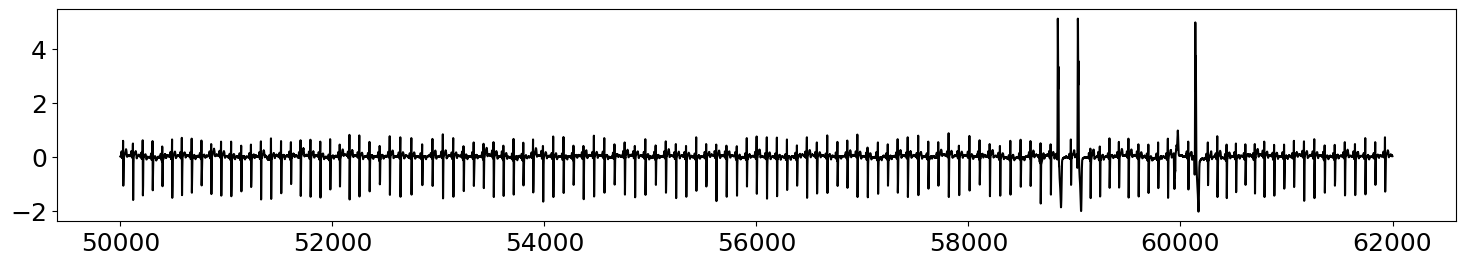

In [5]:
start = 50000
stop = 62000

plt.figure(figsize=(15, 3))
plt.plot(x[start:stop], data[0][start:stop], color='k')
plt.tight_layout()
plt.savefig(figure_path.format('example_ts'), transparent=True)
plt.show()

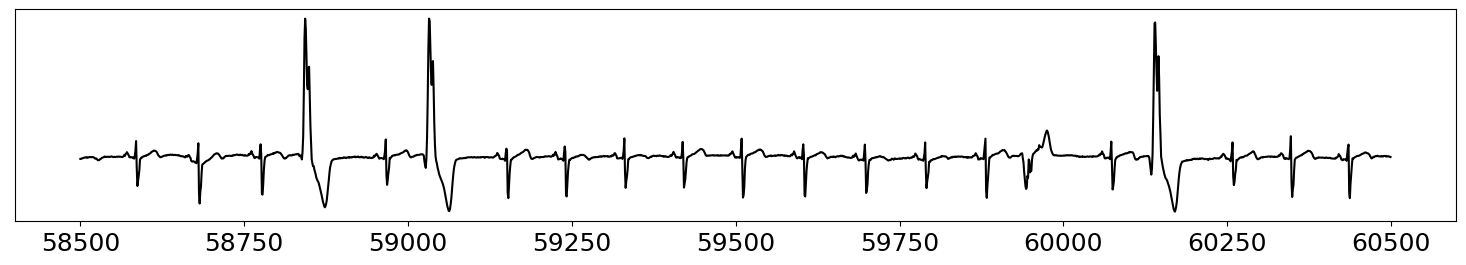

In [19]:
start_an = 58500
stop_an = 60500

plt.figure(figsize=(15, 3))
plt.plot(x[start_an:stop_an], data[0][start_an:stop_an], color='k')
plt.yticks([])
plt.tight_layout()
plt.savefig(figure_path.format('example_subsequence'), transparent=True)
plt.show()

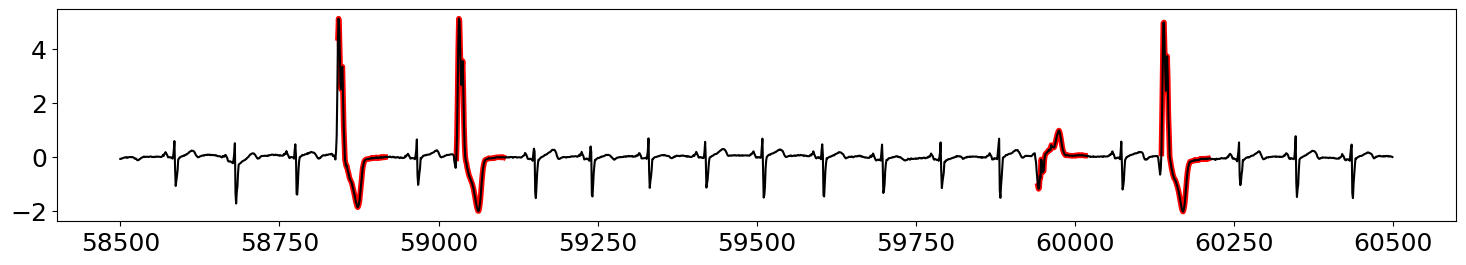

In [14]:
start_an = 58500
stop_an = 60500

plt.figure(figsize=(15, 3))
plt.plot(x[start_an:stop_an], anomalies[start_an:stop_an], linewidth=4, color='red')
plt.plot(x[start_an:stop_an], data[0][start_an:stop_an], color='k')
plt.tight_layout()
plt.savefig(figure_path.format('example_anomaly'), transparent=True)
plt.show()

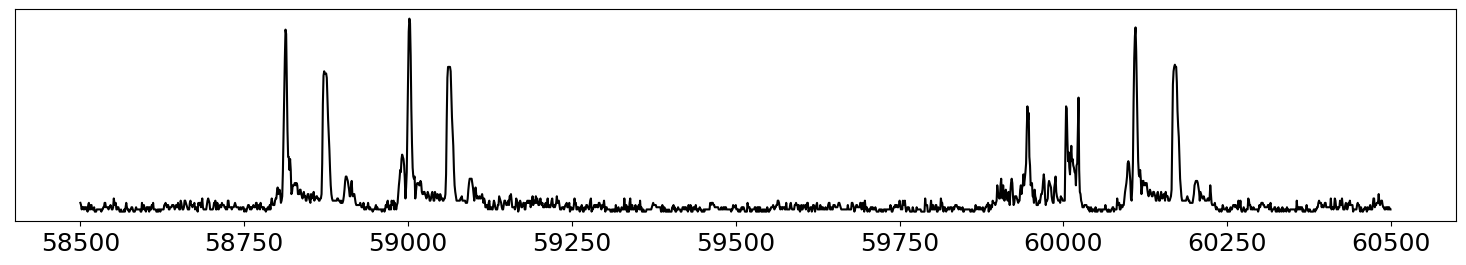

In [18]:
start_an = 58500
stop_an = 60500

plt.figure(figsize=(15, 3))
plt.plot(x[start_an:stop_an], scores[0][start_an:stop_an], color='k')
plt.yticks([])
plt.tight_layout()
plt.savefig(figure_path.format('example_score'), transparent=True)
plt.show()

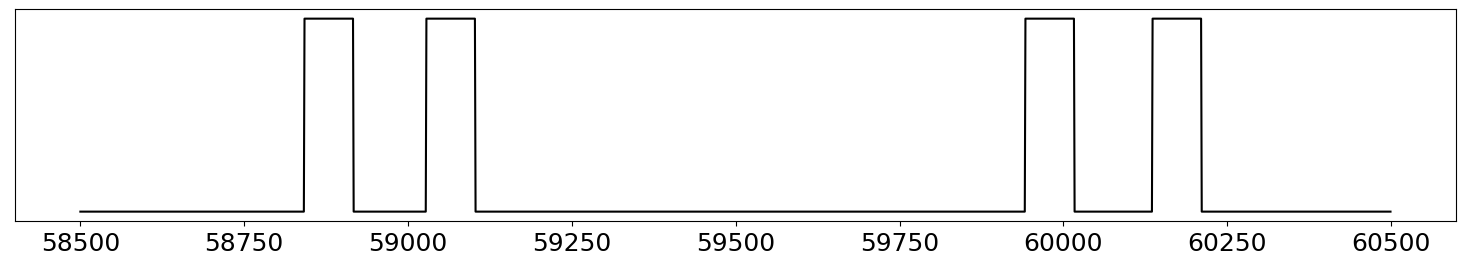

In [17]:
start_an = 58500
stop_an = 60500

plt.figure(figsize=(15, 3))
plt.plot(x[start_an:stop_an], data[1][start_an:stop_an], color='k')
plt.yticks([])
plt.tight_layout()
plt.savefig(figure_path.format('example_labels'), transparent=True)
plt.show()

# Ensemling visual example

In [9]:
detector_names = [
    'AE', 
    'CNN', 
    'HBOS', 
    'IFOREST', 
    'IFOREST1', 
    'LOF', 
    'LSTM', 
    'MP', 
    'NORMA', 
    'OCSVM', 
    'PCA', 
    'POLY'
]

In [10]:
scores = []
for detector in detector_names:
    scores.append(pd.read_csv(score_path + score_file_path.format(detector), header=None).to_numpy().flatten())
scores = np.array(scores)

In [11]:
from sklearn import metrics

def compute_auc_pr(label, score):
    precision, recall, _ = metrics.precision_recall_curve(label, score)
    return metrics.auc(recall, precision)

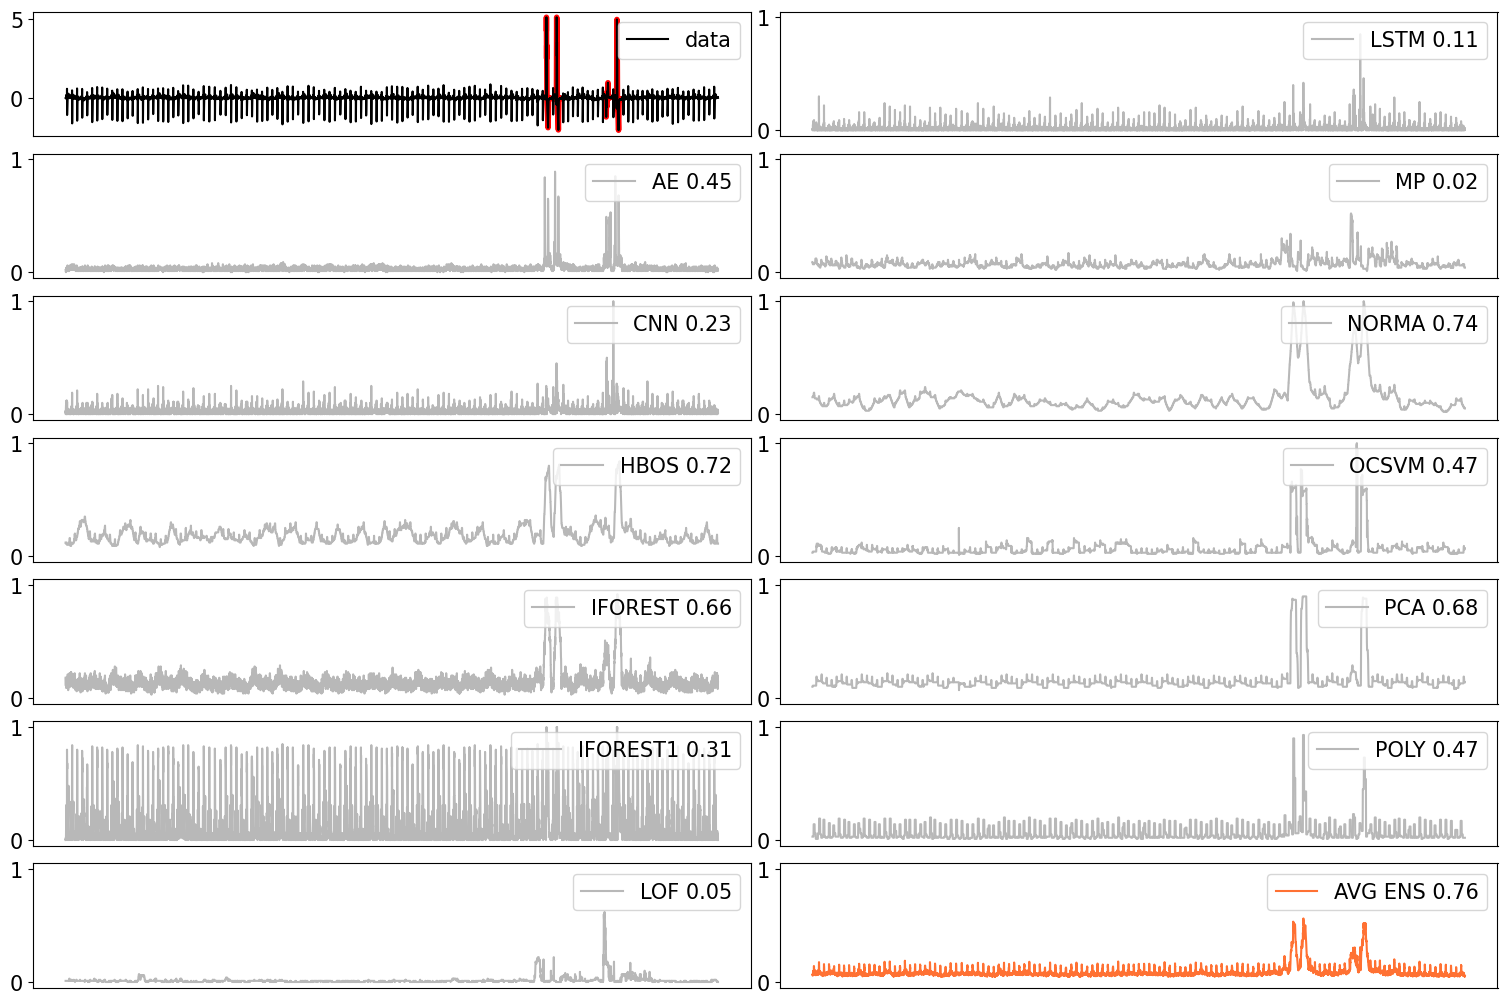

In [202]:
plt.rcParams.update({'font.size': 15})
n_rows = 7
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, sharex=True, figsize=(15, 10))

axes[0, 0].plot(x[start_an:stop_an], anomalies[start_an:stop_an], linewidth=4, color='red')
axes[0, 0].plot(x[start:stop], data[0][start:stop], color='k', label='data')

for i in range(0, 12):
    curr_row = (i + 1) % n_rows
    curr_col = (i + 1) // n_rows
    auc_score = compute_auc_pr(data[1][start:stop], scores[i][start:stop])
    axes[curr_row, curr_col].plot(x[start:stop], scores[i][start:stop], label=f"{detector_names[i]} {auc_score:.2f}", color='#B8B8B8')
    axes[curr_row, curr_col].set_ylim((-0.05, 1.05))

avg_ens = np.average(scores, axis=0)
auc_score = compute_auc_pr(data[1][start:stop], avg_ens[start:stop])
axes[6, 1].plot(x[start:stop], avg_ens[start:stop], label=f"AVG ENS {auc_score:.2f}", color="#FF7133")
axes[6, 1].set_ylim((-0.05, 1.05))

for i in range(0, 14):
    curr_row = i % n_rows
    curr_col = i // n_rows
    axes[curr_row, curr_col].legend(loc='upper right')
    axes[curr_row, curr_col].set_xticks([])
    
plt.tight_layout(pad=0.3)
plt.savefig(figure_path.format('example_ens'), transparent=True)
plt.show()

# AUC-PR visual example

In [181]:
def plot_precision_recall(x, y, name, **kwargs):
    precision, recall, _ = metrics.precision_recall_curve(x, y)    
    precision[0] = 0
    aucpr = np.abs(metrics.auc(recall, precision))
    
    plt.plot(precision, recall, label=f'{name} {aucpr:.2f}', **kwargs)
    
    return precision, recall

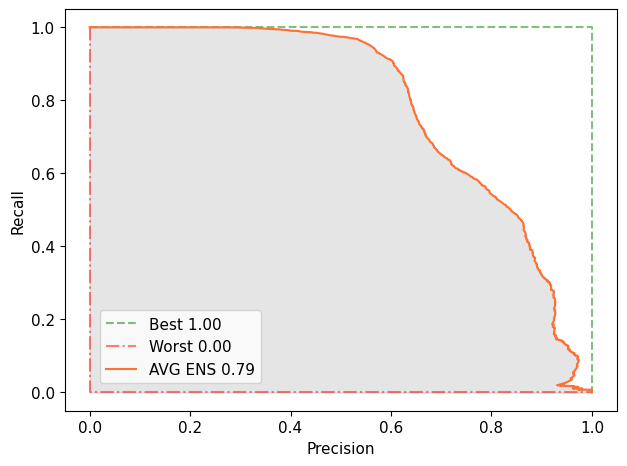

In [190]:
label_inv = np.ones(data[1].shape)
label_inv[data[1] == 1] = 0
aucpr = [4]

plot_precision_recall(data[1], data[1], name='Best', color="green", alpha=0.5, linestyle='dashed')
plot_precision_recall(data[1], label_inv, name='Worst', color="red", alpha=0.5, linestyle='dashdot')

# for i in range(len(detector_names)):
#     plot_precision_recall(data[1], scores[i], name=detector_names[i], linestyle='dotted')

precision, recall = plot_precision_recall(data[1], avg_ens, name='AVG ENS', color="#FF7133")
plt.fill_between(x=precision, y1=recall, y2=0, alpha=0.2, color='grey')

plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend(loc='lower left', bbox_to_anchor=(0.05, 0.05))
plt.tight_layout()
plt.savefig(figure_path.format('aucpr_example'), transparent=True)
plt.show()